In [1]:
%matplotlib inline

In [2]:
#import logging
import os
import random

import numpy as np
import tensorflow as tf

import sys 
sys.path.append(os.path.abspath("/home/himani/learning_to_remember_rare_events"))

import data_utils
import model

import matplotlib.pylab as plt

In [3]:
class flags:
    rep_dim=12 #dimension of keys to use in memory
    episode_length=6 #length of episode 
    episode_width=2 #number of distinct labels in a single episode
    memory_size=None #number of slots in memory
    batch_size=2 #batch size
    num_episodes=20 #number of training episodes
    validation_frequency=5 #every so many training episodes assess validation accuracy
    validation_length=5 #number of episodes to use to compute validation accuracy
    seed=888 #random seed for training sampling
    save_dir='' #directory to save model to
    use_lsh=False #use locality-sensitive hashing (NOTE: not fully tested)
    
FLAGS=flags
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

### Data Exploration

In [4]:
train_data, test_data=data_utils.get_data()

In [5]:
print('Number of train unique classes: %d'%len(train_data))
print('Number of test unique classes: %d'%len(test_data))

Number of train unique classes: 3856
Number of test unique classes: 659


In [6]:
#np.random.seed(100)

In [11]:
i=np.random.choice(train_data.keys())
print(i)
j=np.random.choice(test_data.keys())
print(j)

2800
4376


In [12]:
print('Number of samples per train class: %d'%len(train_data[i]))
print('Number of samples per test class: %d'%len(test_data[j]))

Number of samples per train class: 20
Number of samples per test class: 20


(784,)
(28, 28)


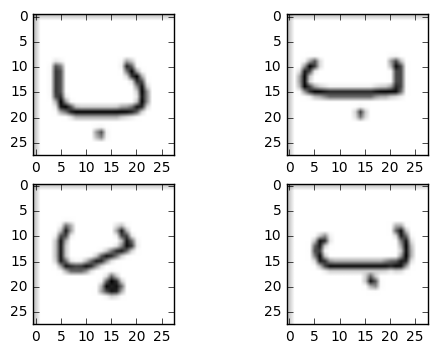

In [13]:
IMAGE_NEW_SIZE = data_utils.IMAGE_NEW_SIZE

for k in range(0,4):
    train_sample=train_data[i][np.random.randint(len(train_data[i]))]
    train_sample_img=np.reshape(train_sample,(IMAGE_NEW_SIZE,IMAGE_NEW_SIZE))
    plt.subplot(2, 2, k+1)
    plt.imshow(train_sample_img,cmap='gray')

print(train_sample.shape)
print(train_sample_img.shape)

### Training code

Fetch data

In [4]:
train_data, valid_data = data_utils.get_data()

train_size = len(train_data)
valid_size = len(valid_data)

print(type(train_data))
print('train_size (number of labels) %d'%(train_size))
print('valid_size (number of labels) %d'%(valid_size))

<type 'dict'>
train_size (number of labels) 3856
valid_size (number of labels) 659


Initialize variables for training, validating, and checkpointing model.

In [5]:
input_dim = data_utils.IMAGE_NEW_SIZE ** 2
output_dim=None
rep_dim = FLAGS.rep_dim
episode_length = FLAGS.episode_length
episode_width = FLAGS.episode_width
batch_size = FLAGS.batch_size
memory_size = (episode_length * batch_size if FLAGS.memory_size is None 
               else FLAGS.memory_size)
use_lsh = FLAGS.use_lsh
output_dim = (output_dim if output_dim is not None 
              else episode_width)
#output_dim = episode_width

assert all(len(v) >= float(episode_length) / episode_width
            for v in train_data.itervalues())
assert all(len(v) >= float(episode_length) / episode_width
            for v in valid_data.itervalues())

print('input_dim %d'%(input_dim))
print('output_dim %d'%(output_dim))
print('rep_dim %d'%(rep_dim))
print('episode_length %d'%(episode_length))
print('episode_width %d'%(episode_width))
print('memory_size %d'%(memory_size))
print('batch_size %d'%(batch_size))

input_dim 784
output_dim 2
rep_dim 12
episode_length 6
episode_width 2
memory_size 12
batch_size 2


Create utility functions

In [6]:
def get_model():
    # vocab size is the number of distinct values that
    # could go into the memory key-value storage
    vocab_size = episode_width * batch_size
    return model.Model(
        input_dim, output_dim, rep_dim, memory_size,
        vocab_size, use_lsh=use_lsh)

def compute_correct(ys, y_preds):
    return np.mean(np.equal(y_preds, np.array(ys)))

def individual_compute_correct(y, y_pred):
    return y_pred == y

def sample_episode_batch(data,episode_length, episode_width, batch_size):
    """Generates a random batch for training or validation.

    Structures each element of the batch as an 'episode'.
    Each episode contains episode_length examples and
    episode_width distinct labels.

    Args:
      data: A dictionary mapping label to list of examples.
      episode_length: Number of examples in each episode.
      episode_width: Distinct number of labels in each episode.
      batch_size: Batch size (number of episodes).

    Returns:
      A tuple (x, y) where x is a list of batches of examples
      with size episode_length and y is a list of batches of labels.
    """
    episodes_x = [[] for _ in xrange(episode_length)]
    episodes_y = [[] for _ in xrange(episode_length)]
    assert len(data) >= episode_width
    keys = data.keys()
    for b in xrange(batch_size):
        episode_labels = random.sample(keys, episode_width)
        remainder = episode_length % episode_width
        remainders = [0] * (episode_width - remainder) + [1] * remainder
        episode_x = [random.sample(data[lab],
                    r + (episode_length - remainder) / episode_width)
                    for lab, r in zip(episode_labels, remainders)]
        episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
                for i, xx in enumerate(episode_x)], [])
        random.shuffle(episode)
        # Arrange episode so that each distinct label is seen before moving to
        # 2nd showing
        episode.sort(key=lambda elem: elem[2])
        assert len(episode) == episode_length
        for i in xrange(episode_length):
            episodes_x[i].append(episode[i][0])
            episodes_y[i].append(episode[i][1] + b * episode_width)

    return ([np.array(xx).astype('float32') for xx in episodes_x],
            [np.array(yy).astype('int32') for yy in episodes_y])

Initialize session and model 

In [7]:
#print('Creating model')
#model = get_model()
#model.setup()

print('Starting session')
config=tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())

ckpt = None
if FLAGS.save_dir:
    ckpt = tf.train.get_checkpoint_state(FLAGS.save_dir)
if ckpt and ckpt.model_checkpoint_path:
    print('restoring from %s'%(ckpt.model_checkpoint_path))
    saver.restore(sess, ckpt.model_checkpoint_path)

Starting session


Perform episodic training and validation

In [18]:
print('starting now')
losses = []
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)
for i in xrange(FLAGS.num_episodes):
    x, y = sample_episode_batch(
    train_data, episode_length, episode_width, batch_size)
    outputs = model.episode_step(sess, x, y, clear_memory=True)
    loss = outputs
    losses.append(loss)
    
    if i % FLAGS.validation_frequency == 0:
        print('\nepisode batch %d, avg train loss %f'%(i, np.mean(losses)))
        losses = []

        # validation
        correct = []
        correct_by_shot = dict((k, []) for k in xrange(episode_width + 1))
        for _ in xrange(FLAGS.validation_length):
            x, y = sample_episode_batch(
                valid_data, episode_length, episode_width, 1)
            outputs = model.episode_predict(sess, x, y, clear_memory=True)
            y_preds = outputs
            correct.append(compute_correct(np.array(y), y_preds))

        # compute per-shot accuracies
        seen_counts = [[0] * episode_width for _ in xrange(batch_size)]
        # loop over episode steps
        for yy, yy_preds in zip(y, y_preds):
        # loop over batch examples
            for k, (yyy, yyy_preds) in enumerate(zip(yy, yy_preds)):
                yyy, yyy_preds = int(yyy), int(yyy_preds)
                count = seen_counts[k][yyy % episode_width]
                if count in correct_by_shot:
                    correct_by_shot[count].append(
                        individual_compute_correct(yyy, yyy_preds))
                seen_counts[k][yyy % episode_width] = count + 1

        print('validation overall accuracy %f'%(np.mean(correct)))
        print_list=sum([[k, np.mean(correct_by_shot[k])]
                        for k in xrange(episode_width + 1)], [])
        print_str=''
        xx=0
        while xx < (len(print_list)):
            print_str=print_str+('%d-shot: %.3f, '%(print_list[xx],print_list[xx+1]))
            xx+=2
        print(print_str)

starting now

episode batch 0, avg train loss 0.265988
validation overall accuracy 0.510000
0-shot: 0.000, 1-shot: 0.600, 2-shot: 0.600, 3-shot: 0.800, 4-shot: 0.400, 5-shot: 1.000, 

episode batch 5, avg train loss 0.194934
validation overall accuracy 0.493333
0-shot: 0.000, 1-shot: 0.400, 2-shot: 0.400, 3-shot: 0.600, 4-shot: 0.800, 5-shot: 0.200, 

episode batch 10, avg train loss 0.171104
validation overall accuracy 0.537333
0-shot: 0.200, 1-shot: 0.400, 2-shot: 0.600, 3-shot: 0.800, 4-shot: 0.800, 5-shot: 1.000, 

episode batch 15, avg train loss 0.161366
validation overall accuracy 0.485333
0-shot: 0.000, 1-shot: 0.400, 2-shot: 0.800, 3-shot: 0.800, 4-shot: 0.600, 5-shot: 0.400, 

episode batch 20, avg train loss 0.154674
validation overall accuracy 0.508667
0-shot: 0.000, 1-shot: 0.200, 2-shot: 0.400, 3-shot: 0.400, 4-shot: 1.000, 5-shot: 1.000, 

episode batch 25, avg train loss 0.152321
validation overall accuracy 0.532667
0-shot: 0.000, 1-shot: 0.400, 2-shot: 0.800, 3-shot: 0

KeyboardInterrupt: 

### Episode check

In [54]:
x, y = sample_episode_batch(train_data, episode_length, episode_width, batch_size)

In [55]:
print(type(x))
print(len(x)) #number of episodes 
print(x[0].shape) #batch size, flattened image
print(y[0].shape) #batch size (labels)

<type 'list'>
30
(16, 784)
(16,)


In [56]:
for ep in y:
    print ep

[ 1  9 14 18 24 27 30 37 44 47 50 57 62 65 70 76]
[ 0  8 10 19 20 29 34 35 41 45 54 56 60 66 73 75]
[ 3  7 12 16 22 25 33 39 42 48 53 59 63 69 74 79]
[ 4  6 13 15 21 26 32 38 40 49 51 58 64 68 72 78]
[ 2  5 11 17 23 28 31 36 43 46 52 55 61 67 71 77]
[ 0  9 10 17 23 26 33 39 42 48 53 57 63 69 70 77]
[ 4  5 11 18 20 29 32 38 44 45 52 56 60 67 72 75]
[ 3  8 13 19 21 25 30 37 40 49 50 55 64 66 74 79]
[ 1  6 12 15 22 28 31 36 43 46 54 58 62 65 73 76]
[ 2  7 14 16 24 27 34 35 41 47 51 59 61 68 71 78]
[ 3  9 10 15 22 26 34 38 43 49 50 59 63 66 70 75]
[ 1  5 11 18 21 29 30 36 44 45 54 57 60 67 73 79]
[ 0  6 14 19 24 25 33 39 41 48 52 55 61 68 72 76]
[ 4  7 13 16 23 27 32 35 42 47 51 58 64 69 71 77]
[ 2  8 12 17 20 28 31 37 40 46 53 56 62 65 74 78]
[ 1  8 11 17 23 29 32 37 43 45 50 57 60 66 74 77]
[ 2  6 12 16 24 26 34 36 41 46 51 56 64 67 73 76]
[ 0  9 14 15 21 25 31 38 42 49 52 58 61 68 70 79]
[ 3  5 13 18 20 27 33 39 40 47 54 55 63 65 72 75]
[ 4  7 10 19 22 28 30 35 44 48 53 59 62 69 71 78]


()


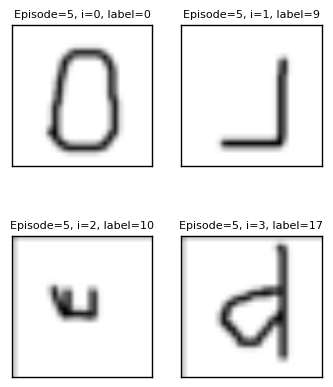

In [57]:
IMAGE_NEW_SIZE = data_utils.IMAGE_NEW_SIZE
fig=plt.figure(figsize=(4,5))

episode_num=5#np.random.choice(episode_length)
print()
for k in range(0,4):
    
    i=k#np.random.choice(batch_size)

    sample_img=x[episode_num][i]
    sample_img=np.reshape(sample_img,(IMAGE_NEW_SIZE,IMAGE_NEW_SIZE))
    plt.subplot(2, 2, k+1)
    plt.imshow(sample_img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Episode=%d, i=%d, label=%d'%(episode_num,i,y[episode_num][i]),fontsize=8)

Sample Episode creation

In [14]:
data=train_data
episode_length=10
episode_width=2
batch_size=1

In [73]:
episodes_x = [[] for _ in xrange(episode_length)]
episodes_y = [[] for _ in xrange(episode_length)]
assert len(data) >= episode_width
keys = data.keys()
print(len(episodes_x))
print(len(keys))

10
3856


In [21]:
random.seed(100)

#randomly sample labels (episode width size)
episode_labels = random.sample(keys, episode_width)

#number of samples per label=int(episode_length/episode_width) + remainder
remainder = episode_length % episode_width
remainders = [0] * (episode_width - remainder) + [1] * remainder

print(episode_labels)
print(remainder)
print(remainders)

[561, 1754]
0
[0, 0]


In [38]:
#randomly sample data sample for each label 
episode_x = [random.sample(data[lab],
             r + (episode_length - remainder) / episode_width)
             for lab, r in zip(episode_labels, remainders)]

print(zip(episode_labels, remainders))
print(len(episode_x)) #number of labels
print(len(episode_x[0])) #number of samples for 1 label 
print(episode_x[0][0].shape)

[(561, 0), (1754, 0)]
2
5
(784,)


In [52]:
for i, xx in enumerate(episode_x):
    for ii, x in enumerate(xx):
        print('i=%d, ii=%d'%(i,ii))
        print(len(xx))
        #print(x.shape)    

i=0, ii=0
5
i=0, ii=1
5
i=0, ii=2
5
i=0, ii=3
5
i=0, ii=4
5
i=1, ii=0
5
i=1, ii=1
5
i=1, ii=2
5
i=1, ii=3
5
i=1, ii=4
5


In [71]:
#create tuple for data_sample, label, sample_id (for rearranging)
episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
               for i, xx in enumerate(episode_x)], [])
print(len(episode))
print(type(episode[0]))
print(len(episode[0]))

for f in range(len(episode)):
    print('data shape: %d, label: %d, sample: %d'
          %(episode[f][0].shape[0],episode[f][1],episode[f][2]))

10
<type 'tuple'>
3
data shape: 784, label: 0, sample: 0
data shape: 784, label: 0, sample: 1
data shape: 784, label: 0, sample: 2
data shape: 784, label: 0, sample: 3
data shape: 784, label: 0, sample: 4
data shape: 784, label: 1, sample: 0
data shape: 784, label: 1, sample: 1
data shape: 784, label: 1, sample: 2
data shape: 784, label: 1, sample: 3
data shape: 784, label: 1, sample: 4


In [72]:
random.shuffle(episode)
# Arrange episode so that each distinct label is seen before moving to
# 2nd showing
episode.sort(key=lambda elem: elem[2])

for f in range(len(episode)):
    print('data shape: %d, label: %d, sample: %d'
          %(episode[f][0].shape[0],episode[f][1],episode[f][2]))

data shape: 784, label: 0, sample: 0
data shape: 784, label: 1, sample: 0
data shape: 784, label: 1, sample: 1
data shape: 784, label: 0, sample: 1
data shape: 784, label: 0, sample: 2
data shape: 784, label: 1, sample: 2
data shape: 784, label: 0, sample: 3
data shape: 784, label: 1, sample: 3
data shape: 784, label: 1, sample: 4
data shape: 784, label: 0, sample: 4


In [79]:
#append samples and labels batch-wise 

b=0 #batch number
assert len(episode) == episode_length
for i in xrange(episode_length):
    episodes_x[i].append(episode[i][0]) #sample data
    episodes_y[i].append(episode[i][1] + b * episode_width) 
    
print(episodes_y)
print(len(episodes_y)) #number of episodes
print(len(episodes_y[0])) #number of batches

[[0], [1], [1], [0], [0], [1], [0], [1], [1], [0]]
10
1


In [81]:
#return tuple of sample points and labels in an episode (batch-wise)
sample_ep=([np.array(xx).astype('float32') for xx in episodes_x],
    [np.array(yy).astype('int32') for yy in episodes_y])

### Memory check

In [43]:
print('starting now')
losses = []

max_iter=FLAGS.num_episodes
max_iter=1

for i in xrange(max_iter):
    x, y = sample_episode_batch(train_data, episode_length, episode_width, batch_size)
    
    #outputs = model.episode_step(sess, x, y, clear_memory=True)
    #loss = outputs #sample-wise loss
    
    outputs = [model.loss, model.gradient_ops, model.memory.get()]
    clear_memory=True
    if clear_memory:
        model.clear_memory(sess)
    #out = sess.run([model.memory.get()])
    #break
        
    loss = []
    for xx, yy in zip(x, y):
        out = sess.run(outputs, feed_dict={model.x: xx, model.y: yy})
        loss.append(out[0])
        
        mem_out=out[2]
        mem_keys, mem_vals, mem_age, recent_idx = mem_out
        
        print('loss: %f'%(out[0]))
        print('y: %s'%(yy))
        print('mem_vals: %s'%(mem_vals)) 
        print('mem_age: %s'%(mem_age))
        print('recent_idx: %s'%(recent_idx))
        print('\n')
    
    losses.append(loss)
    print('iter: %d, loss: %s'%(i,loss))

starting now
loss: 0.000000
y: [1 2]
mem_vals: [0 1 0 0 0 0 0 0 2 0 0 0]
mem_age: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
recent_idx: [0 1 8 0]


loss: 0.464177
y: [0 3]
mem_vals: [0 1 3 0 0 0 0 0 2 0 0 0]
mem_age: [ 2.  1.  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.]
recent_idx: [3 1 8 2]


loss: 0.735076
y: [0 2]
mem_vals: [0 1 3 0 0 0 0 0 2 0 2 0]
mem_age: [ 2.  1.  0.  0.  2.  2.  2.  2.  1.  2.  2.  2.]
recent_idx: [ 9  1 10  2]


loss: 0.217053
y: [1 3]
mem_vals: [0 3 3 0 0 0 0 0 2 0 2 1]
mem_age: [ 3.  2.  1.  1.  3.  3.  3.  3.  2.  0.  0.  3.]
recent_idx: [ 9 11 10  1]


loss: 0.040230
y: [0 3]
mem_vals: [0 3 3 0 0 0 0 0 2 0 2 1]
mem_age: [ 4.  0.  2.  2.  4.  4.  4.  4.  3.  1.  1.  0.]
recent_idx: [ 4 11 10  1]


loss: -0.001252
y: [1 2]
mem_vals: [0 3 2 0 0 0 0 0 2 0 2 1]
mem_age: [ 6.  1.  4.  4.  1.  6.  6.  6.  5.  3.  3.  2.]
recent_idx: [ 4 11  2  1]


iter: 0, loss: [0.0, 0.46417701, 0.73507583, 0.2170534, 0.040230498, -0.0012515709]


In [21]:
len(out)

3

In [22]:
out[0]

0.52287066

In [23]:
out[1]

In [27]:
mem_out=out[2]
mem_keys, mem_vals, mem_age, recent_idx = mem_out

In [29]:
len(mem_keys)

12

In [30]:
mem_vals

array([3, 2, 0, 1, 3, 0, 0, 0, 0, 2, 0, 2], dtype=int32)

In [31]:
y

[array([1, 3], dtype=int32),
 array([0, 2], dtype=int32),
 array([0, 3], dtype=int32),
 array([1, 2], dtype=int32),
 array([0, 2], dtype=int32),
 array([1, 3], dtype=int32)]

In [32]:
mem_age

array([ 3.,  3.,  5.,  5.,  2.,  5.,  5.,  5.,  5.,  0.,  0.,  1.], dtype=float32)

In [33]:
recent_idx

array([10,  3,  9,  0], dtype=int32)

In [36]:
mem_init=out[0]
mem_keys, mem_vals, mem_age, recent_idx = mem_init

In [40]:
recent_idx

array([0, 0, 0, 0], dtype=int32)

### Validation check

In [11]:
print('starting now')
losses = []
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

max_iter=FLAGS.num_episodes
max_iter=1

for i in xrange(max_iter):
    x, y = sample_episode_batch(
    train_data, episode_length, episode_width, batch_size)
    outputs = model.episode_step(sess, x, y, clear_memory=True)
    loss = outputs
    losses.append(loss)
    
    print('\nepisode batch %d, avg train loss %f'%(i, np.mean(losses)))

starting now

episode batch 0, avg train loss 0.279205


Per-shot accuracies

In [12]:
shot_width=int(episode_length/episode_width*1.0)-1
print(shot_width)

5


In [13]:
losses = []
correct = []
correct_by_shot = dict((k, []) for k in xrange(shot_width + 1))
print(correct_by_shot)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: []}


In [14]:
x, y = sample_episode_batch( 
    valid_data, episode_length, episode_width, 1) #batch_size=1

outputs = model.episode_predict(sess, x, y, clear_memory=True)
y_preds = outputs
correct.append(compute_correct(np.array(y), y_preds))

In [15]:
y

[array([1], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32)]

In [16]:
y_preds

[array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([2], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([0], dtype=int32),
 array([2], dtype=int32)]

In [17]:
#how many examples seen per label
seen_counts = [0] * episode_width 
print(seen_counts)

[0, 0, 0]


In [18]:
# loop over episode steps
for yy, yy_preds in zip(y, y_preds):
    # loop over batch examples
    #print('Loop 1: yy=%s,yy_preds=%s'%(yy,yy_preds))
    for (yyy, yyy_preds) in zip(yy, yy_preds):
        
    
        yyy, yyy_preds = int(yyy), int(yyy_preds)
        print('\nLoop 2: yyy=%d,yyy_preds=%d'%(yyy,yyy_preds))
        
        #encoded label number
        print('New label: %d'%(yyy % episode_width))  
        #how many examples seen per label
        print('seen_counts: %s'%(seen_counts))
        
        #how many examples seen so far for this one 
        count = seen_counts[yyy % episode_width] 
        print('this_shot: %d'%(count))
        if count in correct_by_shot:
            correct_by_shot[count].append(
                individual_compute_correct(yyy, yyy_preds))
        else:
            print('Shot not found!!')
            break
        seen_counts[yyy % episode_width] = count + 1
        print('correct_by_shot: %s'%(correct_by_shot))


Loop 2: yyy=1,yyy_preds=0
New label: 1
seen_counts: [0, 0, 0]
this_shot: 0
correct_by_shot: {0: [False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=2,yyy_preds=1
New label: 2
seen_counts: [0, 1, 0]
this_shot: 0
correct_by_shot: {0: [False, False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=0,yyy_preds=1
New label: 0
seen_counts: [0, 1, 1]
this_shot: 0
correct_by_shot: {0: [False, False, False], 1: [], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=0,yyy_preds=2
New label: 0
seen_counts: [1, 1, 1]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=2,yyy_preds=0
New label: 2
seen_counts: [2, 1, 1]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False, False], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=1,yyy_preds=1
New label: 1
seen_counts: [2, 1, 2]
this_shot: 1
correct_by_shot: {0: [False, False, False], 1: [False, False, True], 2: [], 3: [], 4: [], 5: []}

Loop 2: yyy=1,yyy_preds=1
New label: 1
seen_counts: [2,

In [19]:
correct #averaged over validation_length 
print('validation overall accuracy %f'%(np.mean(correct)))

validation overall accuracy 0.222222


In [20]:
print(correct_by_shot)
print_list=sum([[k, np.mean(correct_by_shot[k])]
                        for k in xrange(shot_width + 1)], [])
print(print_list)

{0: [False, False, False], 1: [False, False, True], 2: [True, False, False], 3: [True, False, False], 4: [False, True, False], 5: [False, False, False]}
[0, 0.0, 1, 0.33333333333333331, 2, 0.33333333333333331, 3, 0.33333333333333331]


In [21]:
print_str=''
xx=0
while xx < (len(print_list)):
    print_str=print_str+('%d-shot: %.3f, '%(print_list[xx],print_list[xx+1]))
    xx+=2
print(print_str)

0-shot: 0.000, 1-shot: 0.333, 2-shot: 0.333, 3-shot: 0.333, 


### Memory module

Initializations

In [8]:
def core_builder(x):
    """Embeds x using standard CNN architecture.

    Args:
      x: Batch of images as a 2-d Tensor [batch_size, -1].

    Returns:
      A 2-d Tensor [batch_size, hidden_dim] of embedded images.
    """
    num_channels=1
    image_size = int(input_dim ** 0.5)
    hidden_dim = FLAGS.rep_dim
    matrix_init = tf.truncated_normal_initializer(stddev=0.1)
    vector_init = tf.constant_initializer(0.0)
    
    ch1 = 32 * 2  # number of channels in 1st layer
    ch2 = 64 * 2  # number of channels in 2nd layer
    conv1_weights = tf.get_variable('conv1_w',
                                    [3, 3, num_channels, ch1],
                                    initializer=matrix_init)
    conv1_biases = tf.get_variable('conv1_b', [ch1],
                                   initializer=vector_init)
    conv1a_weights = tf.get_variable('conv1a_w',
                                     [3, 3, ch1, ch1],
                                     initializer=matrix_init)
    conv1a_biases = tf.get_variable('conv1a_b', [ch1],
                                    initializer=vector_init)

    conv2_weights = tf.get_variable('conv2_w', [3, 3, ch1, ch2],
                                    initializer=matrix_init)
    conv2_biases = tf.get_variable('conv2_b', [ch2],
                                   initializer=vector_init)
    conv2a_weights = tf.get_variable('conv2a_w', [3, 3, ch2, ch2],
                                     initializer=matrix_init)
    conv2a_biases = tf.get_variable('conv2a_b', [ch2],
                                    initializer=vector_init)

    # fully connected
    fc1_weights = tf.get_variable(
        'fc1_w', [image_size // 4 * image_size // 4 * ch2,
                  hidden_dim], initializer=matrix_init)
    fc1_biases = tf.get_variable('fc1_b', [hidden_dim],
                                 initializer=vector_init)

    # define model
    x = tf.reshape(x,
                   [-1, image_size, image_size, num_channels])
    batch_size = tf.shape(x)[0]

    conv1 = tf.nn.conv2d(x, conv1_weights,
                         strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    conv1 = tf.nn.conv2d(relu1, conv1a_weights,
                         strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1a_biases))

    pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, conv2_weights,
                         strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    conv2 = tf.nn.conv2d(relu2, conv2a_weights,
                         strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2a_biases))

    pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1], padding='SAME')

    reshape = tf.reshape(pool2, [batch_size, -1])
    hidden = tf.matmul(reshape, fc1_weights) + fc1_biases

    return hidden

In [9]:
#inits, only once
key_dim=FLAGS.rep_dim
memory_size=memory_size
vocab_size=episode_width * batch_size
choose_k= min(256, memory_size)
alpha=0.1
correct_in_top=1
age_noise=8.0
var_cache_device='' # Variables are cached here.
nn_device='' # Device to perform nearest neighbour matmul.

caching_device = var_cache_device if var_cache_device else None
update_memory = tf.constant(True)  # Can be fed "false" if needed.



In [10]:
mem_keys = tf.get_variable(
    'memkeys', [memory_size, key_dim], trainable=False,
    initializer=tf.random_uniform_initializer(-0.0, 0.0),
    caching_device=caching_device)

mem_vals = tf.get_variable(
    'memvals', [memory_size], dtype=tf.int32, trainable=False,
    initializer=tf.constant_initializer(0, tf.int32),
    caching_device=caching_device)

mem_age = tf.get_variable(
    'memage', [memory_size], dtype=tf.float32, trainable=False,
    initializer=tf.constant_initializer(0.0), caching_device=caching_device)

recent_idx = tf.get_variable(
    'recent_idx', [vocab_size], dtype=tf.int32, trainable=False,
    initializer=tf.constant_initializer(0, tf.int32))

# variable for projecting query vector into memory key
query_proj = tf.get_variable(
    'memory_query_proj', [key_dim, key_dim], dtype=tf.float32,
    initializer=tf.truncated_normal_initializer(0, 0.01),
    caching_device=caching_device)

In [11]:
def get():
    return mem_keys, mem_vals, mem_age, recent_idx

def set(k, v, a, r=None):
    return tf.group(
        mem_keys.assign(k),
        mem_vals.assign(v),
        mem_age.assign(a),
        (recent_idx.assign(r) if r is not None else tf.group()))

def clear():
    return tf.variables_initializer([mem_keys, mem_vals, mem_age,recent_idx])


In [19]:
def get_hint_pool_idxs(normalized_query):
    """Get small set of idxs to compute nearest neighbor queries on.

    This is an expensive look-up on the whole memory that is used to
    avoid more expensive operations later on.

    Args:
      normalized_query: A Tensor of shape [None, key_dim].

    Returns:
      A Tensor of shape [None, choose_k] of indices in memory
      that are closest to the queries.

    """
    # look up in large memory, no gradients
    with tf.device(nn_device):
        similarities = tf.matmul(tf.stop_gradient(normalized_query),mem_keys, transpose_b=True, name='nn_mmul')
    _, hint_pool_idxs = tf.nn.top_k(tf.stop_gradient(similarities), k=choose_k, name='nn_topk')
    
    return hint_pool_idxs

def make_update_op(upd_idxs, upd_keys, upd_vals,batch_size, use_recent_idx, intended_output):
    """Function that creates all the update ops."""
    mem_age_incr = mem_age.assign_add(tf.ones([memory_size],dtype=tf.float32))
    with tf.control_dependencies([mem_age_incr]):
        mem_age_upd = tf.scatter_update(mem_age, upd_idxs, tf.zeros([batch_size], dtype=tf.float32))

    mem_key_upd = tf.scatter_update(mem_keys, upd_idxs, upd_keys)
    mem_val_upd = tf.scatter_update(mem_vals, upd_idxs, upd_vals)

    if use_recent_idx:
        recent_idx_upd = tf.scatter_update(recent_idx, intended_output, upd_idxs)
    else:
        recent_idx_upd = tf.group()

    return tf.group(mem_age_upd, mem_key_upd, mem_val_upd, recent_idx_upd)

In [20]:
"""
Queries memory for nearest neighbor.
query_vec: A batch of vectors to query (embedding of input to model).
intended_output: The values that would be the correct output of the memory.
use_recent_idx: Whether to always insert at least one instance of a correct memory fetch.
"""

#inputs
X=tf.placeholder(tf.float32, [None, input_dim])
Y=tf.placeholder(tf.int32, [None])

embeddings = core_builder(X)
query_vec=embeddings
intended_output=Y

use_recent_idx=True

In [21]:
batch_size = tf.shape(query_vec)[0]
output_given = intended_output is not None

#prepare query for memory lookup
query_vec = tf.matmul(query_vec, query_proj)

normalized_query = tf.nn.l2_normalize(query_vec, dim=1)


In [16]:
query_vec

<tf.Tensor 'MatMul_1:0' shape=(?, 12) dtype=float32>

In [32]:
hint_pool_idxs = get_hint_pool_idxs(normalized_query)

In [35]:
if output_given and use_recent_idx:  # add at least one correct memory
    most_recent_hint_idx = tf.gather(recent_idx, intended_output)
    hint_pool_idxs = tf.concat(axis=1,values=[hint_pool_idxs, tf.expand_dims(most_recent_hint_idx, 1)])

choose_k_new = tf.shape(hint_pool_idxs)[1]

In [19]:
hint_pool_idxs

<tf.Tensor 'concat:0' shape=(?, 13) dtype=int32>

In [44]:
with tf.device(var_cache_device):
    # create small memory and look up with gradients
    my_mem_keys = tf.stop_gradient(tf.gather(mem_keys, hint_pool_idxs,name='my_mem_keys_gather'))
    similarities = tf.matmul(tf.expand_dims(normalized_query, 1),my_mem_keys, adjoint_b=True, name='batch_mmul')
    
    hint_pool_sims = tf.squeeze(similarities, [1], name='hint_pool_sims')
    hint_pool_mem_vals = tf.gather(mem_vals, hint_pool_idxs,name='hint_pool_mem_vals')
    
# Calculate softmax mask on the top-k if requested.
# Softmax temperature. Say we have K elements at dist x and one at (x+a).
# Softmax of the last is e^tm(x+a)/Ke^tm*x + e^tm(x+a) = e^tm*a/K+e^tm*a.
# To make that 20% we'd need to have e^tm*a ~= 0.2K, so tm = log(0.2K)/a.
softmax_temp = max(1.0, np.log(0.2 * choose_k) / alpha)
mask = tf.nn.softmax(hint_pool_sims[:, :choose_k_new - 1] * softmax_temp)

In [62]:
# prepare hints from the teacher on hint pool
teacher_hints = tf.to_float(tf.abs(tf.expand_dims(intended_output, 1) - hint_pool_mem_vals))
teacher_hints = 1.0 - tf.minimum(1.0, teacher_hints)

teacher_vals, teacher_hint_idxs = tf.nn.top_k(hint_pool_sims * teacher_hints, k=1)
neg_teacher_vals, _ = tf.nn.top_k(hint_pool_sims * (1 - teacher_hints), k=1)

# bring back idxs to full memory
teacher_idxs = tf.gather(tf.reshape(hint_pool_idxs, [-1]),teacher_hint_idxs[:, 0] + choose_k_new * tf.range(batch_size))

# zero-out teacher_vals if there are no hints
teacher_vals *= (1 - tf.to_float(tf.equal(0.0, tf.reduce_sum(teacher_hints, 1))))

# prepare returned values
nearest_neighbor = tf.to_int32(tf.argmax(hint_pool_sims[:, :choose_k_new - 1], 1))
no_teacher_idxs = tf.gather(tf.reshape(hint_pool_idxs, [-1]),nearest_neighbor + choose_k_new * tf.range(batch_size))

In [71]:
# we'll determine whether to do an update to memory based on whether
# memory was queried correctly
sliced_hints = tf.slice(teacher_hints, [0, 0], [-1, correct_in_top])
incorrect_memory_lookup = tf.equal(0.0, tf.reduce_sum(sliced_hints, 1))

# loss based on triplet loss
teacher_loss = (tf.nn.relu(neg_teacher_vals - teacher_vals + alpha)- alpha)

with tf.device(var_cache_device):
    result = tf.gather(mem_vals, tf.reshape(no_teacher_idxs, [-1]))

In [79]:
# prepare memory updates
update_keys = normalized_query
update_vals = intended_output

fetched_idxs = teacher_idxs  # correctly fetched from memory
with tf.device(var_cache_device):
    fetched_keys = tf.gather(mem_keys, fetched_idxs, name='fetched_keys')
    fetched_vals = tf.gather(mem_vals, fetched_idxs, name='fetched_vals')

# do memory updates here
fetched_keys_upd = update_keys + fetched_keys  # Momentum-like update
fetched_keys_upd = tf.nn.l2_normalize(fetched_keys_upd, dim=1)

# Randomize age a bit, e.g., to select different ones in parallel workers.
mem_age_with_noise = mem_age + tf.random_uniform([memory_size], - age_noise, age_noise)
_, oldest_idxs = tf.nn.top_k(mem_age_with_noise, k=batch_size, sorted=False)

In [86]:
with tf.control_dependencies([result]):
    upd_idxs = tf.where(incorrect_memory_lookup,oldest_idxs,fetched_idxs)
    # upd_idxs = tf.Print(upd_idxs, [upd_idxs], "UPD IDX", summarize=8)
    upd_keys = tf.where(incorrect_memory_lookup,update_keys,fetched_keys_upd)
    upd_vals = tf.where(incorrect_memory_lookup,update_vals,fetched_vals)

In [93]:
def make_update_op_new():
    return make_update_op(upd_idxs, upd_keys, upd_vals,batch_size, use_recent_idx, intended_output)

update_op = tf.cond(update_memory, make_update_op_new, tf.no_op)

with tf.control_dependencies([update_op]):
    result = tf.identity(result)
    mask = tf.identity(mask)
    teacher_loss = tf.identity(teacher_loss)

In [30]:
"""
result: The result of the memory look up.
mask: The affinity of the query to the result.
teacher_loss: The loss for training the memory module.
"""
mean_teacher_loss=tf.reduce_mean(teacher_loss)
#result, mask, tf.reduce_mean(teacher_loss)

In [12]:
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

print('starting now')

starting now


In [13]:
batch_size_int=2
x, y = sample_episode_batch(train_data, episode_length, episode_width, batch_size_int)

In [14]:
print(x[0].shape) #btach size, input size
print(y[0].shape)

(2, 784)
(2,)


In [23]:
clear_memory=True
sess.run(tf.global_variables_initializer())
if clear_memory:
    sess.run([clear()])

In [16]:
xy=zip(x, y)
print(xy[0][0].shape)
print(xy[0][1].shape)

(2, 784)
(2,)


In [18]:
#outputs = [result, mask, mean_teacher_loss]

idx=0
xx, yy = xy[idx]

In [ ]:
out = sess.run(outputs, feed_dict={X: xx, Y: yy})

In [58]:
len(out)

3

In [65]:
out[0]

array([0, 2], dtype=int32)

In [67]:
out[2]

-0.021480739